In [1]:
%load_ext autoreload 
#hopefully this will reload the modules when they are changed specifically when i change the plotting modules
%autoreload 2

In [2]:
import iapi_TNG as iapi
#this package contains useful functions for downloading the neccessary data
#make sure you have edited iapi_TNG.py to include your personal API key
import numpy as np
import h5py #most TNG data is downloaded as hdf5 files
import matplotlib.pyplot as plt
import matplotlib.markers as mkr
import os.path
from os import path
import scipy.stats as st
from utilities.draw_contour import conplot
from utilities.plot_gen import plot_gen, plot_wcontour
from utilities.bin_data import bin_data, avg, sort_mass
import pandas as pd
#from scipy.stats import binned_statistic
 
baseUrl = 'http://www.tng-project.org/api/'

## Initialization

In [3]:
####EDIT THIS FOR YOUR MACHINE#####
#get current director
'!pwd'
#get current directory
currentdirc=!pwd
print(currentdirc)
dirc= ' '.join(currentdirc) + '/TNG_workshop_data/'
print(f"current dirc {dirc}")

['/Users/alexpoulin/Downloads/git/TNG/TNG_workshop']
current dirc /Users/alexpoulin/Downloads/git/TNG/TNG_workshop/TNG_workshop_data/


In [4]:
###specify which simulation you want to explore###
sim='TNG100-1'

r=iapi.get(baseUrl)
print(r)
#check the properties of the simulation you have selected
simUrl = baseUrl+sim
print(simUrl) 
simdata = iapi.get(simUrl)
print(simdata['description'])
simdata.keys()

{'simulations': [{'name': 'Illustris-1', 'num_snapshots': 134, 'url': 'http://www.tng-project.org/api/Illustris-1/'}, {'name': 'Illustris-1-Dark', 'num_snapshots': 136, 'url': 'http://www.tng-project.org/api/Illustris-1-Dark/'}, {'name': 'Illustris-2', 'num_snapshots': 136, 'url': 'http://www.tng-project.org/api/Illustris-2/'}, {'name': 'Illustris-2-Dark', 'num_snapshots': 136, 'url': 'http://www.tng-project.org/api/Illustris-2-Dark/'}, {'name': 'Illustris-3', 'num_snapshots': 136, 'url': 'http://www.tng-project.org/api/Illustris-3/'}, {'name': 'Illustris-3-Dark', 'num_snapshots': 136, 'url': 'http://www.tng-project.org/api/Illustris-3-Dark/'}, {'name': 'TNG100-1', 'num_snapshots': 100, 'url': 'http://www.tng-project.org/api/TNG100-1/'}, {'name': 'TNG100-1-Dark', 'num_snapshots': 100, 'url': 'http://www.tng-project.org/api/TNG100-1-Dark/'}, {'name': 'TNG100-2', 'num_snapshots': 100, 'url': 'http://www.tng-project.org/api/TNG100-2/'}, {'name': 'TNG100-2-Dark', 'num_snapshots': 100, 'url

dict_keys(['name', 'description', 'name_alt', 'boxsize', 'z_start', 'z_final', 'cosmology', 'omega_0', 'omega_L', 'omega_B', 'hubble', 'physics_model', 'has_cooling', 'has_starformation', 'has_winds', 'has_blackholes', 'mass_gas', 'mass_dm', 'softening_dm_comoving', 'softening_stars_comoving', 'softening_blackholes_comoving', 'softening_gas_comoving', 'softening_dm_max_phys', 'softening_stars_max_phys', 'softening_blackholes_max_phys', 'softening_gas_max_phys', 'softening_gas_factor', 'softening_gas_comoving_min', 'num_dm', 'num_tr_mc', 'num_tr_vel', 'longids', 'is_uniform', 'is_zoom', 'is_subbox', 'num_files_snapshot', 'num_files_groupcat', 'num_files_rockstar', 'num_files_lhalotree', 'num_files_sublink', 'num_files_ctrees', 'filesize_lhalotree', 'filesize_sublink', 'filesize_ctrees', 'filesize_ics', 'filesize_simulation', 'has_fof', 'has_subfind', 'has_rockstar', 'has_lhalotree', 'has_sublink', 'has_ctrees', 'permission_required', 'num_snapshots', 'url', 'parent_simulation', 'child_s

## Get Data

In [5]:
if not os.path.exists(dirc + 'catalogs'):
    os.makedirs(dirc + 'catalogs')
    print(f'created directory: {dirc} "catalogs"')
if not os.path.exists(dirc + 'catalogs/SubhaloFlag'):
    os.makedirs(dirc + 'catalogs/SubhaloFlag')
    print(f'created directory: {dirc} "/catalogs/SubhaloFlag"')
flag=iapi.getSubhaloField('SubhaloFlag',simulation=sim,fileName=dirc+'catalogs/SubhaloFlag',rewriteFile=0)

#### Get Mass

In [6]:

#let's fetch a field that will tell us about the mass of the galaxy
#SubhaloMassType gives the total mass of all bound particles, separated by particle type
mass=iapi.getSubhaloField('SubhaloMassType',simulation=sim,fileName=dirc+'catalogs/MassType',rewriteFile=0)
print(mass.shape)

#Pull the stellar mass: 
print(mass[:,3])
stellar_mass=mass[:,4]
print(stellar_mass)

h = simdata.get('hubble')
print(h)
stellar_mass=stellar_mass*10**10/h #convert to one solar masses

(4371211, 6)
[0. 0. 0. ... 0. 0. 0.]
[251.01631   37.85255   42.482437 ...   0.         0.         0.      ]
0.6774


#### Save SFR

In [7]:
if not os.path.exists(dirc + 'catalogs/SubhaloSFR'):
    os.makedirs(dirc + 'catalogs/SubhaloSFR')
    print(f'created directory: {dirc} "catalogs/SubhaloSFR"')
sfr_inst = iapi.getSubhaloField('SubhaloSFR',simulation = sim,fileName=dirc+'catalogs/SubhaloSFR',rewriteFile=0)

#### Get group number

In [8]:
if not os.path.exists(dirc + 'catalogs/SubhaloGrNr'):
    os.makedirs(dirc + 'catalogs/SubhaloGrNr')
    print(f'created directory: {dirc} "catalogs/SubhaloGrNr"')
groupNum = iapi.getSubhaloField('SubhaloGrNr',simulation = sim,fileName=dirc+'catalogs/SubhaloGrNr',rewriteFile=0)

#### Get magnetic field

In [9]:
if not os.path.exists(dirc + 'catalogs/SubhaloBfldHalo'):
    os.makedirs(dirc + 'catalogs/SubhaloBfldHalo')
    print(f'created directory: {dirc} "catalogs/SubhaloBfldHalo"')
Bfld = iapi.getSubhaloField('SubhaloBfldHalo',simulation = sim,fileName=dirc+'catalogs/SubhaloBfldHalo',rewriteFile=0)
#Multiply B field by h*2.6*10^-6 to get Gauss
Bfld = Bfld*h*2.6*10**-6

#put bfld in microgauss
Bfld=Bfld*10**6

#### Restrict to 10^9 solar masses

In [10]:
subID=np.arange(0,len(stellar_mass))

mask = (flag==1) & (stellar_mass>10**9)

print("Before trimming, there are ", len(stellar_mass), ' subhalos in our catalog')

IDs_m=subID[mask]
s_mass=stellar_mass[mask]
sfr_i = sfr_inst[mask]
groupNum_m = groupNum[mask]
Bfld_m = Bfld[mask]


print("After trimming, there are ", len(s_mass), ' subhalos in our catalog')

Before trimming, there are  4371211  subhalos in our catalog
After trimming, there are  21052  subhalos in our catalog


## Seperate satellites from centrals

In [11]:
print(all(groupNum_m[i] <= groupNum_m[i + 1] for i in range(len(groupNum_m) - 1))) #prints true if already sorted
groups = sorted(set(groupNum_m))  # Ensure unique and ordered group identifiers

# Initialize separate resulting arrays for a, b, and group c
grouped_s_mass = [[] for _ in groups]  # Each sub-list will store values ofmass
grouped_sfr_i = [[] for _ in groups]  # Each sub-list will store values of sfr
grouped_groupNum_i = [[] for _ in groups]  # Each sub-list will store corresponding group identifiers
grouped_bfld = [[] for _ in groups]  # Each sub-list will store values of Bfld
grouped_ids = [[] for _ in groups]  # Each sub-list will store values of ids

# Group values into separate lists
for i in range(len(groupNum_m)):
    group_index = groups.index(groupNum_m[i])  # Determine the index for each group
    #group_index = np.where(groups == groupNum_m[i])[0]
    grouped_s_mass[group_index].append(s_mass[i])
    grouped_sfr_i[group_index].append(sfr_i[i])
    grouped_bfld[group_index].append(Bfld_m[i])
    grouped_groupNum_i[group_index].append(groupNum_m[i])
    grouped_ids[group_index].append(IDs_m[i])

True


In [12]:
#most massive of group
centrals_mass = []
satellites_mass = []
centrals_bfld = []
satellites_bfld = []
centrals_ids = []
satellites_ids = []
centrals_sfri = []
satellites_sfri = []

grouped_sfr_i_only_satellites = []


# Find largest/central galaxy in each group
for i, group in enumerate(groups):
    max_s_mass = max(grouped_s_mass[i])  # Find the maximum value in the mass for this group
    
    centrals_mass.append(max_s_mass) 
    centrals_bfld.append(grouped_bfld[i][grouped_s_mass[i].index(max_s_mass)])  # Find the Bfld value for the central galaxy
    centrals_sfri.append(grouped_sfr_i[i][grouped_s_mass[i].index(max_s_mass)])  # Find the SFR value for the central galaxy
    centrals_ids.append(grouped_ids[i][grouped_s_mass[i].index(max_s_mass)])  # Find the ID for the central galaxy
    
    satellites_mass.append(grouped_s_mass[i].copy()) #need to copy since we are appending a list object --> this is reference
    satellites_bfld.append(grouped_bfld[i].copy())
    satellites_sfri.append(grouped_sfr_i[i])
    satellites_mass[i].remove(max_s_mass)  # Remove the central galaxy from the list of satellites
    satellites_bfld[i].remove(centrals_bfld[i])  # Remove the central galaxy from the list of satellites
    satellites_ids.append(grouped_ids[i].copy())
    satellites_ids[i].remove(centrals_ids[i])  # Remove the central galaxy from the list of satellites
    
    grouped_sfr_i_only_satellites.append(grouped_sfr_i[i].copy())
    grouped_sfr_i_only_satellites[i].remove(centrals_sfri[i])  # Remove the central galaxy from the list of satellites 

In [13]:
def flatten(xss):
    flat_list = []
    for xs in xss:
        for x in xs:
            flat_list.append(x)
    return flat_list

satellites_mass_fl = flatten(satellites_mass)
satellites_sfri_fl = flatten(satellites_sfri)
satellites_bfld_fl = flatten(satellites_bfld)
satellites_ids_fl = flatten(satellites_ids)


## Separate Isolated from Non-Isolated centrals

In [14]:
#Define isolated centrals as those with no star-forming satellites 
# (all other subhalos with the same SubhaloGrNr have SubhaloSFR=0)
#define non-isolated centrals as those with star-forming satellites:
# (at least one other subhalo with the same SubhaloGrNr has SubhaloSFR>0)
isolated_centrals_mass = []
isolated_centrals_bfld = []
non_isolated_centrals_mass = []
non_isolated_centrals_bfld = []

isolated_centrals_sfri = []
non_isolated_centrals_sfri = []

non_isolated_centrals_ids = []
isolated_centrals_ids = []

#for each group, check if there are any star-forming satellites
# if there are, the central is non-isolated so find the central who belongs to that group
# if there are no star-forming satellites, the central is isolated
# so find the central who belongs to that group
for i, group in enumerate(groups):
    #print(f"Grouped sfr {grouped_sfr_i[i]}:")
    if any(sfr > 0 for sfr in grouped_sfr_i_only_satellites[i]):
        non_isolated_centrals_mass.append(centrals_mass[i])
        non_isolated_centrals_bfld.append(centrals_bfld[i])
        non_isolated_centrals_sfri.append(centrals_sfri[i]) #groups should be same length as centrals_* so no need to index
        non_isolated_centrals_ids.append(centrals_ids[i])
    else:
        isolated_centrals_mass.append(centrals_mass[i])
        isolated_centrals_bfld.append(centrals_bfld[i])
        isolated_centrals_sfri.append(centrals_sfri[i])
        isolated_centrals_ids.append(centrals_ids[i])



## Get merger
For Pre/Post Infall Satellites

In [15]:
#Box boundary 
L=75000. #kpc
halfbox=L/2.   
h=0.6774 

r=iapi.get(baseUrl)
names = [sim['name'] for sim in r['simulations']]
i = names.index('TNG100-1')
simulation = iapi.get( r['simulations'][i]['url'] )
snaps = iapi.get( simulation['snapshots'] )

In [16]:

def gettree(subid, par_dir):
    #pull the z=0 merger tree for a subhlao
    #some subhalos don't have merger trees
    fName = str(par_dir)+'trees/sublink_mpb_'+str(subid)
    if path.exists(fName+'.hdf5'):
        return(fName+'.hdf5')
    url='https://www.tng-project.org/api/TNG100-1/snapshots/99/subhalos/'+str(subid)+'/sublink/mpb.hdf5'
    tree=iapi.get(url,fName=fName)
    return(tree)

def getredshift(snapnum):
    #convert a snapshot number to a redshift
    return(snaps[snapnum]['redshift'])

#### Real Join Time
Note that this code defines joining time as the time since a satellite first approached its FoF group center within 3*R200 (R200 is a measurement of radius).

For magnetic field project, define joining time as the earliest time when the host and satellite had the same SubhaloGrNr 

In [17]:
def jointime(ID,hostID, par_dir):
    """
    Use the satellite and host trees to find the joining redshift of a satellite based on when it first approached its z=0 FoF group within 3R200
    Identify the change in satellite parameters since they joined
    """


    #fetch the merger tree for the satellite
    try:
        print(f'attempting tree http for: {ID}, {hostID}')
        mpb1 = gettree(ID, dirc)
    except:
        print(f'failure in tree http for: {ID}, {hostID}')
        return(np.nan,np.nan,np.nan,np.nan,np.nan, np.nan, np.nan, np.nan, np.nan, np.nan,
               np.nan, np.nan, np.nan) #correlates to R200 = 1, 2, 3
    f = h5py.File(mpb1,'r')
    subPos = f['SubhaloPos'][:]
    snapnum= f['SnapNum'][:]
    subVel = f['SubhaloVel'][:]
    subMasstype = f['SubhaloMassType'][:]
    progID = f['SubfindID'][:]
    
    #fetch the merger tree for the satellite's host

    mpbhost =gettree(hostID, dirc)
    fh = h5py.File(mpbhost,'r')
    grPos = fh['GroupPos'][:]
    grR200 = fh['Group_R_Crit200'][:]
    grVel = fh['SubhaloVel'][:]
    hostprog = fh['SubhaloID']
    

    # to compare distances, first make arrays the same shapes
    # sometimes trees are "truncated," meaning they don't go all the way back to the start of the simulation
    if len(grPos)>len(subPos):         
        grPos=grPos[0:len(subPos),:]
        grR200=grR200[0:len(subPos)]
        grVel = grVel[0:len(subPos),:]

    elif len(grPos)<len(subPos):
        subPos=subPos[0:len(grPos),:]
        subVel=subVel[0:len(grPos),:]
        snapnum = snapnum[0:len(grPos)]
        subMasstype = subMasstype[0:len(grPos),:]

    
    #Taking a square root is computationally inefficient.
    #Because distance in 3D is calculated with x^2+y^2+z^2 = distance^2,
    #I just work with distances in squares until the last step

    grR200sq = np.multiply(grR200,grR200) #looking within 3R200 to get joining time for more satellites
    
    #Find the relative distance between two galaxies
    difpos=np.subtract(subPos,grPos)
    
    #The simulation uses repeating boundary conditions. 
    # So two galaxies can be quite close, even if they are technically at either end of the box

    #Replace values that are affected by boundary conditions
    difpos = np.where(abs(difpos)>halfbox,abs(difpos)-L, difpos)
    
    #Find the distance square between satellite and central as a function of redshift
    distsq=np.sum(np.square(difpos),axis=1)


    wh=np.nonzero((distsq<grR200sq))
    
    #Separation at z=0
    sep_z0 = np.sqrt(distsq[0])
    sep_norm = sep_z0/grR200[0]
    #Find when the 
    closeind = np.argmin(distsq)
    closest = np.sqrt(distsq[closeind])
    closest_norm = closest/grR200[closeind]
    closest_z = getredshift(snapnum[closeind])
    
    

    #Find when the satellite first crosses one,two,three R_200
    #aka find the index at which the distsq less than the correesponding R200sq
    cross1R200ind = np.where((distsq<=1*grR200sq))
    cross2R200ind = np.where((distsq<=4*grR200sq))
    cross3R200ind = np.where((distsq<=9*grR200sq))
    if len(cross1R200ind[0])>0:
        first1R200 = np.sqrt(distsq[cross1R200ind[0][0]])
    else:
        first1R200 = np.nan
    if len(cross2R200ind[0])>0:
        first2R200 = np.sqrt(distsq[cross2R200ind[0][0]])
    else:
        first2R200 = np.nan
    if len(cross3R200ind[0])>0:
        first3R200 = np.sqrt(distsq[cross3R200ind[0][0]])
    else:
        first3R200 = np.nan
    
    
    #wh=np.nonzero((distsq<grR200sq) & (distsq>4*grR200sq))
    
    
    if len(wh[0])==0: 
        #in some cases, the satellite has never approached within the required distance
        #this shouldn't trigger when satellite joining redshift is defined by SubhaloGrNr
        print('not within 3')
        return(np.nan,sep_z0,sep_norm,np.nan,closest, closest_norm, closest_z, np.nan, np.nan, np.nan,
               first1R200, first2R200, first3R200) #correlates to R200 = 1, 2, 3

    
    #find the index at which the satellite joined 
    joinind = max(wh[0])
    whinside=snapnum[wh]
    whID = progID[wh] #ID of the "progenitor" galaxy of the subhalo, used to pull progenitor cutout in other code
    minind = np.argmin(whinside)
    
    joinsnap=whinside[minind]
    joinprog = whID[minind]
    joinred = getredshift(joinsnap)
    
    print(f'joinsnap: {joinsnap}')
    
    s_mass_j = subMasstype[joinind][4]
    
    hostprog_ID  = hostprog[joinind]
    
    return(joinred,sep_z0,sep_norm,joinsnap,closest, closest_norm, closest_z, joinprog, s_mass_j, hostprog_ID,
           first1R200, first2R200, first3R200) #correlates to R200 = 1, 2, 3


### iterate over all satellites

In [18]:
#return(joinred,sep_z0,sep_norm,joinsnap,closest, closest_norm, 
# closest_z, joinprog, s_mass_j, hostprog_ID)

joinred = np.full(len(IDs_m), np.nan)
sep = np.full(len(IDs_m), np.nan)
sep_norm = np.full(len(IDs_m), np.nan)

joinsnap = np.full(len(IDs_m), np.nan)
closest = np.full(len(IDs_m), np.nan)
closest_norm = np.full(len(IDs_m), np.nan)
closest_z = np.full(len(IDs_m), np.nan)
joinprog = np.full(len(IDs_m), np.nan)

s_mass_j = np.full(len(IDs_m),np.nan)
hostprogID = np.full(len(IDs_m), np.nan)

cross1R200 = np.full(len(IDs_m), np.nan)
cross2R200 = np.full(len(IDs_m), np.nan)
cross3R200 = np.full(len(IDs_m), np.nan)

#iterate over each value in groupNum_uniq
for i in range(0,len(centrals_mass)):    
    #go through each iteration of satellites and go through the length of that
    for j in range(0,len(satellites_mass[i])):
        joinred[i], sep[i], sep_norm[i], joinsnap[i], closest[i], closest_norm[i], closest_z[i], joinprog[i], \
            s_mass_j[i], hostprogID[i], cross1R200[i], cross2R200[i], cross3R200[i] = jointime(satellites_ids[i][j],centrals_ids[i], dirc)

print(joinred)
    

attempting tree http for: 1, 0
not within 3
attempting tree http for: 2, 0
joinsnap: 99
attempting tree http for: 3, 0
not within 3
attempting tree http for: 4, 0
not within 3
attempting tree http for: 5, 0
joinsnap: 99
attempting tree http for: 6, 0
joinsnap: 96
attempting tree http for: 7, 0
joinsnap: 74
attempting tree http for: 8, 0
joinsnap: 98
attempting tree http for: 9, 0
joinsnap: 91
attempting tree http for: 10, 0
joinsnap: 89
attempting tree http for: 11, 0
joinsnap: 65
attempting tree http for: 12, 0
not within 3
attempting tree http for: 13, 0
joinsnap: 78
attempting tree http for: 14, 0
joinsnap: 97
attempting tree http for: 15, 0
not within 3
attempting tree http for: 16, 0
joinsnap: 79
attempting tree http for: 17, 0
not within 3
attempting tree http for: 18, 0
joinsnap: 78
attempting tree http for: 19, 0
joinsnap: 53
attempting tree http for: 20, 0
not within 3
attempting tree http for: 21, 0
joinsnap: 52
attempting tree http for: 22, 0
joinsnap: 91
attempting tree htt

# Define Pre/Post Infall based on Closest Approach
We want to define join times by when the satellite was no longer in the same FoF group as its z=0 central.


Find the distance between satellites and central as a function of redshift
Save the "joining redshift" of each satellite galaxy, which will be the highest redshift (lowest snapshot #) that the satellite and its central had the same SubhaloGrNr

If satellites are the closest they've ever been to their central galaxy at present-day (present day means snapnum=99, corresponding to z=0), define them to be pre-infall satellites.
If satellites were closer to their central galaxy some time between present-day and when they joined the same FoF group as their hosts, define them to be post-infall satellites. 
For post-infall satellites, save their "pericenter distance" which is the separation between central and satellite galaxy when they were at their closest. Normalize the pericenter distance by the group's R200 at that redshift (see the definition of "closest_norm" in the example code to see what I mean).

### Plot closest appraoch with Binning

In [19]:

#sort centrals
isolated_centrals_mass_sort_log, isolated_centrals_bfld_sort_log, isolated_centrals_sfri_sort = sort_mass(np.log10(isolated_centrals_mass), np.log10(isolated_centrals_bfld), isolated_centrals_sfri)
non_isolated_centrals_mass_sort_log, non_isolated_centrals_bfld_sort_log, non_isolated_centrals_sfri_sort = sort_mass(np.log10(non_isolated_centrals_mass), np.log10(non_isolated_centrals_bfld), non_isolated_centrals_sfri)

#bin the data
bin_size = 100
isolated_centrals_mass_bin_log, isolated_centrals_mass_bin_log_er, isolated_centrals_mass_bin_log_sem_er = bin_data(isolated_centrals_mass_sort_log, int(bin_size*1.1))
isolated_centrals_bfld_bin_log, isolated_centrals_bfld_bin_log_er, isolated_centrals_bfld_bin_log_sem_er = bin_data(isolated_centrals_bfld_sort_log, int(bin_size*1.1))
non_isolated_centrals_mass_bin_log, non_isolated_centrals_mass_bin_log_er, non_isolated_centrals_mass_bin_log_sem_er = bin_data(non_isolated_centrals_mass_sort_log, int(bin_size*0.3))
non_isolated_centrals_bfld_bin_log, non_isolated_centrals_bfld_bin_log_er, none_isolated_centrals_bfld_bin_log_sem_er = bin_data(non_isolated_centrals_bfld_sort_log, int(bin_size*0.3))



# Define prefall/postfall based on Cross R200
It may be the case that whatever process is causing the magnetic field to amplify is occurring well before "infall" as it is currently defined. We can test different definitions of infall as when the satellite first cross 1, 2, or 3 R_200. R_200 corresponds to the virial radius of the FoF group (Group_R_Crit200 in the FoF catalog). 

In [20]:
def defInfall(condition):
    def_pre_infall = []
    def_pre_infall_m = []
    def_pre_infall_b = []
    def_pre_infall_ID = []

    def_post_infall = []
    def_post_infall_m = []
    def_post_infall_b = []
    def_post_infall_ID = []
    
    def_pre_infall_sfri = []
    def_post_infall_sfri = []
    
    for i in range(0,len(satellites_mass_fl)):
        #if less than 10^-9 then pre_infall
        #print(cross3R200[i])
        if np.isnan(condition[i]):
            def_pre_infall.append(closest_z[i])
            def_pre_infall_m.append(satellites_mass_fl[i])
            def_pre_infall_b.append(satellites_bfld_fl[i])
            def_pre_infall_ID.append(satellites_ids_fl[i])
            def_pre_infall_sfri.append(satellites_sfri_fl[i])
        else:
            def_post_infall.append(closest_z[i])
            def_post_infall_m.append(satellites_mass_fl[i])
            def_post_infall_b.append(satellites_bfld_fl[i])
            def_post_infall_ID.append(satellites_ids_fl[i])
            def_post_infall_sfri.append(satellites_sfri_fl[i])
    return def_pre_infall, def_pre_infall_m, def_pre_infall_b, def_pre_infall_ID,\
        def_post_infall, def_post_infall_m, def_post_infall_b, def_post_infall_ID,\
            def_pre_infall_sfri, def_post_infall_sfri

In [21]:
pre_infall_1, pre_infall_1_mass, pre_infall_1_bfld, pre_infall_1_ID, \
    post_infall_1, post_infall_1_mass, post_infall_1_bfld, post_infall_1_ID, \
        pre_infall_1_sfri, post_infall_1_sfri = defInfall(cross1R200)
pre_infall_2, pre_infall_2_mass, pre_infall_2_bfld, pre_infall_2_ID, \
    post_infall_2, post_infall_2_mass, post_infall_2_bfld, post_infall_2_ID, \
        pre_infall_2_sfri, post_infall_2_sfri = defInfall(cross2R200)
pre_infall_3, pre_infall_3_mass, pre_infall_3_bfld, pre_infall_3_ID, post_infall_3, \
    post_infall_3_mass, post_infall_3_bfld, post_infall_3_ID, \
        pre_infall_3_sfri, post_infall_3_sfri = defInfall(cross3R200)

In [22]:
#sort the pre and log both
pre_infall_1_mass_sort_log, pre_infall_1_bfld_sort_log, pre_infall_1_sfri_sort = sort_mass(np.log10(pre_infall_1_mass), np.log10(pre_infall_1_bfld), pre_infall_1_sfri)
post_infall_1_mass_sort_log, post_infall_1_bfld_sort_log, post_infall_1_sfri_sort = sort_mass(np.log10(post_infall_1_mass), np.log10(post_infall_1_bfld), post_infall_1_sfri)

#bin the data (centrals already binned from before)
bin_size = 100
pre_infall_1_mass_bin_log, pre_infall_1_mass_bin_er_log, pre_infall_1_mass_bin_sem_er_log = bin_data(pre_infall_1_mass_sort_log, bin_size)
pre_infall_1_bfld_bin_log, pre_infall_1_bfld_bin_er_log, pre_infall_1_bfld_bin_sem_er_log = bin_data(pre_infall_1_bfld_sort_log, bin_size)
post_infall_1_mass_bin_log, post_infall_1_mass_bin_er_log, post_infall_1_mass_bin_sem_er_log = bin_data(post_infall_1_mass_sort_log, int(bin_size * 0.2))
post_infall_1_bfld_bin_log, post_infall_1_bfld_bin_er_log, post_infall_1_bfld_bin_sem_er_log = bin_data(post_infall_1_bfld_sort_log, int(bin_size * 0.2))


isolated_centrals_mass_bin_log, isolated_centrals_mass_bin_er_log, isolated_centrals_mass_bin_sem_er_log = bin_data(isolated_centrals_mass_sort_log, int(bin_size * 1.1))
isolated_centrals_bfld_bin_log, isolated_centrals_bfld_bin_er_log, isolated_centrals_bfld_bin_sem_er_log = bin_data(isolated_centrals_bfld_sort_log, int(bin_size * 1.1))

non_isolated_centrals_mass_bin_log, non_isolated_centrals_mass_bin_er_log, non_isolated_centrals_mass_bin_sem_er_log = bin_data(non_isolated_centrals_mass_sort_log, int(bin_size * 0.2))
non_isolated_centrals_bfld_bin_log, non_isolated_centrals_bfld_bin_er_log, non_isolated_centrals_bfld_bin_sem_er_log = bin_data(non_isolated_centrals_bfld_sort_log, int(bin_size * 0.2))

### Plot 1R200

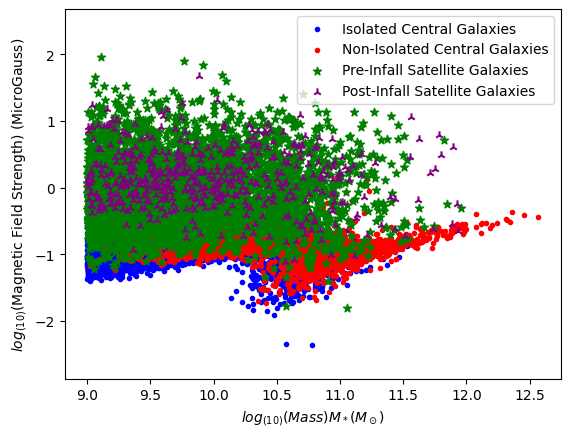

In [23]:
##plot no bin
plot_gen(np.log10(isolated_centrals_mass), np.log10(isolated_centrals_bfld), 
         np.log10(non_isolated_centrals_mass), np.log10(non_isolated_centrals_bfld), 
         np.log10(pre_infall_1_mass), np.log10(pre_infall_1_bfld), 
         np.log10(post_infall_1_mass), np.log10(post_infall_1_bfld), 
         'cross-1R200.png', log=False)

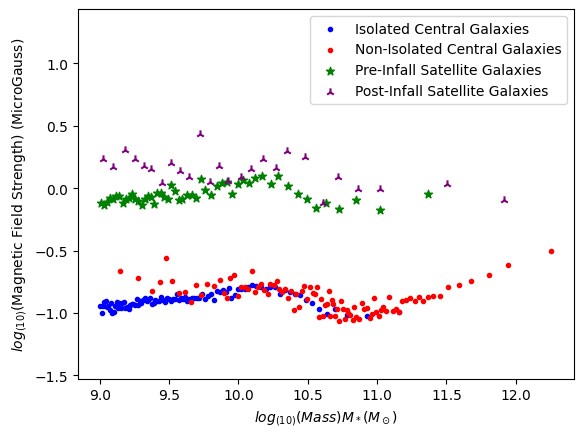

In [24]:
#plot binned
plot_gen(isolated_centrals_mass_bin_log, isolated_centrals_bfld_bin_log, 
         non_isolated_centrals_mass_bin_log, non_isolated_centrals_bfld_bin_log, 
         pre_infall_1_mass_bin_log, pre_infall_1_bfld_bin_log, 
         post_infall_1_mass_bin_log, post_infall_1_bfld_bin_log, 'binnedz-cross-1R200.png', log=False)

# Plot only SFRI != 0

In [25]:
#note we're only separating by pre and post infall, not by isolated and non-isolated centrals
#we can do that if we want to but it's not necessary

#reuse the sorted mass and bfld from earlier

#remove from mass and bfld where sfri == 0
mask = np.where(pre_infall_1_sfri_sort != 0)
pre_infall_1_mass_log_sfri = np.array(pre_infall_1_mass_sort_log)[mask]
pre_infall_1_bfld_log_sfri = np.array(pre_infall_1_bfld_sort_log)[mask]
mask = np.where(post_infall_1_sfri_sort != 0)
post_infall_1_mass_log_sfri = np.array(post_infall_1_mass_sort_log)[mask]
post_infall_1_bfld_log_sfri = np.array(post_infall_1_bfld_sort_log)[mask]


#bin the data 
bin_size = 100
pre_infall_1_mass_bin_log_sfri, pre_infall_1_mass_bin_er_log_sfri, pre_infall_1_mass_bin_sem_er_log_sfri = bin_data(pre_infall_1_mass_log_sfri, int(bin_size*1.7))
pre_infall_1_bfld_bin_log_sfri, pre_infall_1_bfld_bin_er_log_sfri, pre_infall_1_bfld_bin_sem_er_log_sfri = bin_data(pre_infall_1_bfld_log_sfri, int(bin_size*1.7))
post_infall_1_mass_bin_log_sfri, post_infall_1_mass_bin_er_log_sfri, post_infall_1_mass_bin_sem_er_log_sfri = bin_data(post_infall_1_mass_log_sfri, int(bin_size*0.15))
post_infall_1_bfld_bin_log_sfri, post_infall_1_bfld_bin_er_log_sfri, post_infall_1_bfld_bin_sem_er_log_sfri = bin_data(post_infall_1_bfld_log_sfri, int(bin_size*0.15))


#reuse the sorted central mass and bfld from earlier

# hypothetically if we were to separate by isolated and non-isolated centrals
mask = np.where(non_isolated_centrals_sfri_sort != 0)
# mask = np.nonzero(non_isolated_centrals_sfri)[0]
# print(mask)
non_isolated_centrals_mass_sort_log_sfri = np.array(non_isolated_centrals_mass_sort_log)[mask]
non_isolated_centrals_bfld_sort_log_sfri = np.array(non_isolated_centrals_bfld_sort_log)[mask]
mask = np.where(isolated_centrals_sfri_sort != 0)
# mask = np.nonzero(isolated_centrals_sfri)
isolated_centrals_mass_sort_log_sfri = np.array(isolated_centrals_mass_sort_log)[mask]
isolated_centrals_bfld_sort_log_sfri = np.array(isolated_centrals_bfld_sort_log)[mask]

# #bin the data 
bin_size = 100
isolated_centrals_mass_bin_log_sfri, isolated_centrals_mass_bin_er_log_sfri, isolated_centrals_mass_bin_sem_er_log_sfri = bin_data(isolated_centrals_mass_sort_log_sfri, int(bin_size * 3.5))
isolated_centrals_bfld_bin_log_sfri, isolated_centrals_bfld_bin_er_log_sfri, isolated_centrals_bfld_bin_sem_er_log_sfri = bin_data(isolated_centrals_bfld_sort_log_sfri, int(bin_size * 3.5))
non_isolated_centrals_mass_bin_log_sfri, non_isolated_centrals_mass_bin_er_log_sfri, non_isolated_centrals_mass_bin_sem_er_log_sfri = bin_data(non_isolated_centrals_mass_sort_log_sfri, int(bin_size * 0.9))
non_isolated_centrals_bfld_bin_log_sfri, non_isolated_centrals_bfld_bin_er_log_sfri, non_isolated_centrals_bfld_bin_sem_er_log_sfri = bin_data(non_isolated_centrals_bfld_sort_log_sfri, int(bin_size * 0.9))



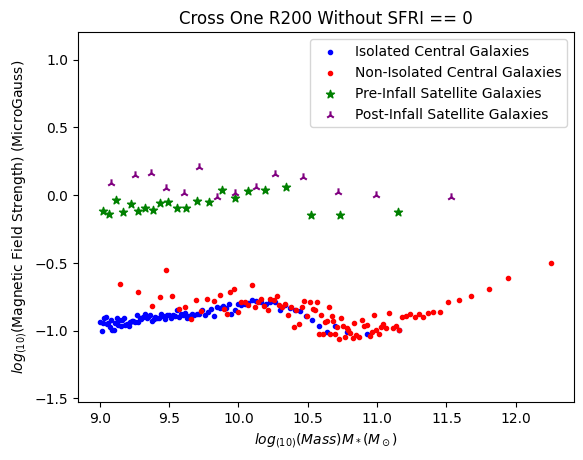

In [26]:
#plot binned
plot_gen(isolated_centrals_mass_bin_log, isolated_centrals_bfld_bin_log, 
         non_isolated_centrals_mass_bin_log, non_isolated_centrals_bfld_bin_log, 
         pre_infall_1_mass_bin_log_sfri, pre_infall_1_bfld_bin_log_sfri, 
         post_infall_1_mass_bin_log_sfri, post_infall_1_bfld_bin_log_sfri, 'binned-cross-1R200-sfri.png', 
         log=False, title="Cross One R200 Without SFRI == 0")

## Draw Contours and Error bars

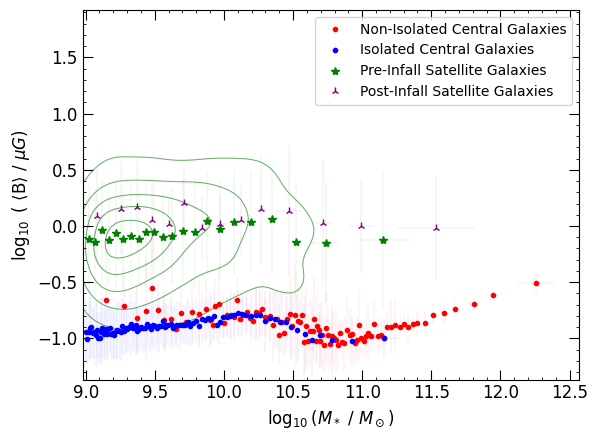

In [27]:
#pdf
plot_wcontour(isolated_centrals_mass_bin_log, isolated_centrals_bfld_bin_log,
            non_isolated_centrals_mass_bin_log, non_isolated_centrals_bfld_bin_log,
            pre_infall_1_mass_bin_log_sfri, pre_infall_1_bfld_bin_log_sfri, 
            post_infall_1_mass_bin_log_sfri, post_infall_1_bfld_bin_log_sfri,
            isolated_centrals_mass_bin_er_log, isolated_centrals_bfld_bin_er_log,
            non_isolated_centrals_mass_bin_er_log, non_isolated_centrals_bfld_bin_er_log,
            pre_infall_1_mass_bin_er_log_sfri, pre_infall_1_bfld_bin_er_log_sfri,
            post_infall_1_mass_bin_er_log_sfri, post_infall_1_bfld_bin_er_log_sfri,
            pre_infall_1_mass_log_sfri, pre_infall_1_bfld_log_sfri,
            filename = 'binned-cross-1R200-contour-sfri.pdf', log=False, title="", contAlph=0.6, alph=0.3)

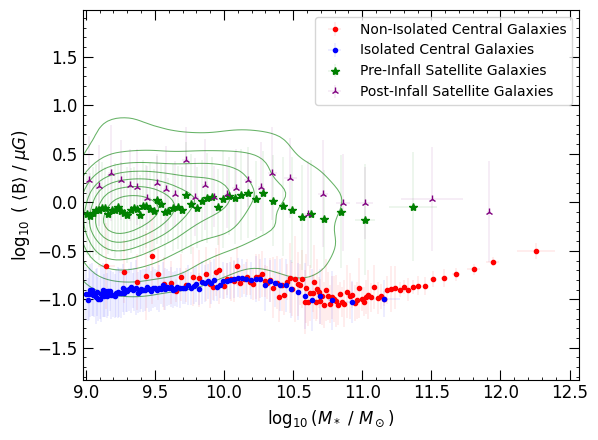

In [28]:
#with pdf
plot_wcontour(isolated_centrals_mass_bin_log, isolated_centrals_bfld_bin_log,
            non_isolated_centrals_mass_bin_log, non_isolated_centrals_bfld_bin_log,
            pre_infall_1_mass_bin_log, pre_infall_1_bfld_bin_log, 
            post_infall_1_mass_bin_log, post_infall_1_bfld_bin_log,
            isolated_centrals_mass_bin_er_log, isolated_centrals_bfld_bin_er_log,
            non_isolated_centrals_mass_bin_er_log, non_isolated_centrals_bfld_bin_er_log,
            pre_infall_1_mass_bin_er_log, pre_infall_1_bfld_bin_er_log,
            post_infall_1_mass_bin_er_log, post_infall_1_bfld_bin_er_log,
            pre_infall_1_mass_sort_log, pre_infall_1_bfld_sort_log,
            filename = 'binned-cross-1R200-contour.pdf', log=False, contAlph=0.6, alph=0.5)

# Plot un-logged but Binned

In [29]:
print(len(pre_infall_1_mass), len(pre_infall_1_bfld))
print(pre_infall_1_sfri)

7332 7332
[np.float32(2.227189), np.float32(17.392204), np.float32(1.4146897), np.float32(0.88655853), np.float32(2.1843414), np.float32(0.0), np.float32(0.0), np.float32(0.0), np.float32(0.0), np.float32(0.0), np.float32(0.013021496), np.float32(0.0), np.float32(0.0), np.float32(0.0), np.float32(0.0), np.float32(0.45162132), np.float32(0.0), np.float32(2.2517612), np.float32(0.0), np.float32(0.0), np.float32(0.0), np.float32(1.7775145), np.float32(0.5442667), np.float32(0.0), np.float32(0.0), np.float32(0.0), np.float32(4.5309973), np.float32(0.0), np.float32(0.0), np.float32(0.0), np.float32(0.43490863), np.float32(0.47551575), np.float32(1.2807658), np.float32(0.86516815), np.float32(0.0), np.float32(0.0), np.float32(0.0), np.float32(0.0), np.float32(0.0), np.float32(0.0), np.float32(0.0), np.float32(0.0), np.float32(0.0), np.float32(0.0), np.float32(0.0), np.float32(0.0), np.float32(0.0), np.float32(0.0), np.float32(0.0), np.float32(0.0), np.float32(0.0), np.float32(1.0861278), np.

In [30]:
#sort the pre
pre_infall_1_mass_sort, pre_infall_1_bfld_sort, pre_infall_1_sfri_sort = sort_mass(pre_infall_1_mass, pre_infall_1_bfld, pre_infall_1_sfri)
post_infall_1_mass_sort, post_infall_1_bfld_sort, post_infall_1_sfri_sort = sort_mass(post_infall_1_mass, post_infall_1_bfld, post_infall_1_sfri)

#sort centrals
isolated_centrals_mass_sort, isolated_centrals_bfld_sort, isolated_centrals_sfri_sort = sort_mass(isolated_centrals_mass, isolated_centrals_bfld, isolated_centrals_sfri)
non_isolated_centrals_mass_sort, non_isolated_centrals_bfld_sort, non_isolated_centrals_sfri_sort = sort_mass(non_isolated_centrals_mass, non_isolated_centrals_bfld, non_isolated_centrals_sfri)


In [31]:
print(len(pre_infall_1_mass_sort), len(pre_infall_1_bfld_sort), len(pre_infall_1_sfri_sort))
print(len(np.where(pre_infall_1_sfri_sort != 0)[0]))

5169 5169 5169
3648


In [32]:
#note we're only separating by pre and post infall, not by isolated and non-isolated centrals
#we can do that if we want to but it's not necessary

#reuse the sorted mass and bfld from earlier

#remove from mass and bfld where sfri == 0
mask = np.where(pre_infall_1_sfri_sort != 0)
pre_infall_1_mass_sort_sfri = np.array(pre_infall_1_mass_sort)[mask]
pre_infall_1_bfld_sort_sfri = np.array(pre_infall_1_bfld_sort)[mask]
mask = np.where(post_infall_1_sfri_sort != 0)
post_infall_1_mass_sort_sfri = np.array(post_infall_1_mass_sort)[mask]
post_infall_1_bfld_sort_sfri = np.array(post_infall_1_bfld_sort)[mask]


#bin the data 
bin_size = 100
pre_infall_1_mass_bin_sfri, pre_infall_1_mass_bin_er_sfri, pre_infall_1_mass_bin_sem_er_sfri = bin_data(pre_infall_1_mass_sort_sfri, int(bin_size*1.3))
pre_infall_1_bfld_bin_sfri, pre_infall_1_bfld_bin_er_sfri, pre_infall_1_bfld_bin_sem_er_sfri = bin_data(pre_infall_1_bfld_sort_sfri, int(bin_size*1.3))
post_infall_1_mass_bin_sfri, post_infall_1_mass_bin_er_sfri, post_infall_1_mass_bin_sem_er_sfri = bin_data(post_infall_1_mass_sort_sfri, int(bin_size*0.05))
post_infall_1_bfld_bin_sfri, post_infall_1_bfld_bin_er_sfri, post_infall_1_bfld_bin_sem_er_sfri = bin_data(post_infall_1_bfld_sort_sfri, int(bin_size*0.05))


#reuse the sorted central mass and bfld from earlier

# hypothetically if we were to separate by isolated and non-isolated centrals
mask = np.where(non_isolated_centrals_sfri_sort != 0)
# mask = np.nonzero(non_isolated_centrals_sfri)[0]
# print(mask)
non_isolated_centrals_mass_sort_sfri = np.array(non_isolated_centrals_mass_sort)[mask]
non_isolated_centrals_bfld_sort_sfri = np.array(non_isolated_centrals_bfld_sort)[mask]
mask = np.where(isolated_centrals_sfri_sort != 0)
# mask = np.nonzero(isolated_centrals_sfri)
isolated_centrals_mass_sort_sfri = np.array(isolated_centrals_mass_sort)[mask]
isolated_centrals_bfld_sort_sfri = np.array(isolated_centrals_bfld_sort)[mask]

# #bin the data 
bin_size = 100
isolated_centrals_mass_bin_sfri, isolated_centrals_mass_bin_er_sfri, isolated_centrals_mass_bin_sem_er_sfri = bin_data(isolated_centrals_mass_sort_sfri, int(bin_size * 2.8))
isolated_centrals_bfld_bin_sfri, isolated_centrals_bfld_bin_er_sfri, isolated_centrals_bfld_bin_sem_er_sfri = bin_data(isolated_centrals_bfld_sort_sfri, int(bin_size * 2.8))
non_isolated_centrals_mass_bin_sfri, non_isolated_centrals_mass_bin_er_sfri, non_isolated_centrals_mass_bin_sem_er_sfri = bin_data(non_isolated_centrals_mass_sort_sfri, int(bin_size * 0.6))
non_isolated_centrals_bfld_bin_sfri, non_isolated_centrals_bfld_bin_er_sfri, non_isolated_centrals_bfld_bin_sem_er_sfri = bin_data(non_isolated_centrals_bfld_sort_sfri, int(bin_size * 0.6))



## plot all sfri with bins and not logged

In [33]:
#print num pre-infall-1 bfld that is zero
print(pre_infall_1_bfld_sort_sfri)
print(len(np.where(pre_infall_1_bfld_sort_sfri == 0)[0]))

[0.47601616 1.19571376 1.16011584 ... 0.31624553 0.26890853 5.11946249]
0


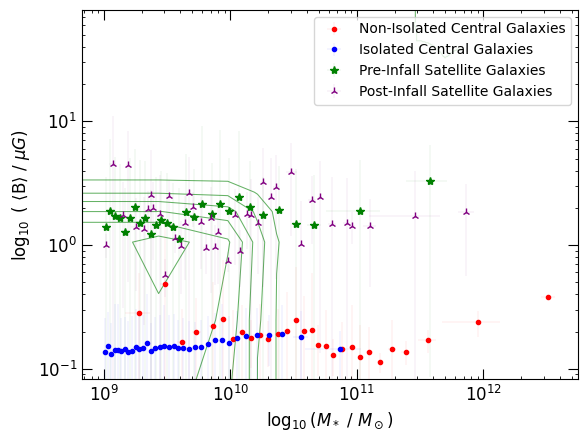

In [34]:
plot_wcontour(isolated_centrals_mass_bin_sfri, isolated_centrals_bfld_bin_sfri,
            non_isolated_centrals_mass_bin_sfri, non_isolated_centrals_bfld_bin_sfri,
            pre_infall_1_mass_bin_sfri, pre_infall_1_bfld_bin_sfri, 
            post_infall_1_mass_bin_sfri, post_infall_1_bfld_bin_sfri,
            isolated_centrals_mass_bin_er_sfri, isolated_centrals_bfld_bin_er_sfri,
            non_isolated_centrals_mass_bin_er_sfri, non_isolated_centrals_bfld_bin_er_sfri,
            pre_infall_1_mass_bin_er_sfri, pre_infall_1_bfld_bin_er_sfri,
            post_infall_1_mass_bin_er_sfri, post_infall_1_bfld_bin_er_sfri,
            pre_infall_1_mass_sort_sfri, pre_infall_1_bfld_sort_sfri,
            filename = 'binned-cross-1R200-contour-sfri-unlogged.pdf', log=True, title="", contAlph=0.6, alph=0.3)

## all sfri without bins and not logged

/Users/alexpoulin/Downloads/git/TNG/TNG_workshop/utilities/plot_gen.py:52: UserWarning: Attempt to set non-positive ylim on a log-scaled axis will be ignored.
  plt.ylim(min(isoCen_bfld) - 0.5, max(postInf_bfld) + 1)


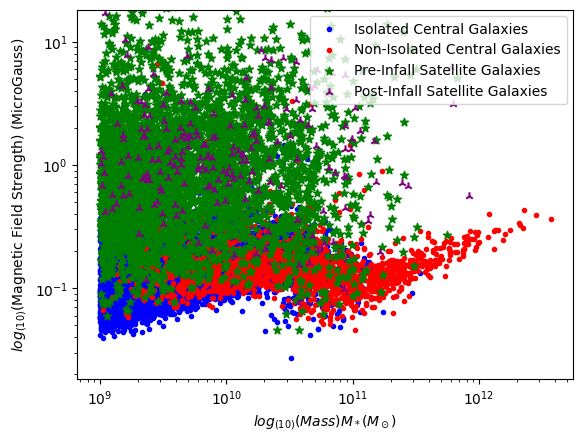

In [35]:
plot_gen(isolated_centrals_mass_sort_sfri, isolated_centrals_bfld_sort_sfri,
            non_isolated_centrals_mass_sort_sfri, non_isolated_centrals_bfld_sort_sfri,
            pre_infall_1_mass_sort_sfri, pre_infall_1_bfld_sort_sfri, 
            post_infall_1_mass_sort_sfri, post_infall_1_bfld_sort_sfri,
            'binned-cross-1R200-contour-sfri-unbinned-unlogged.pdf', log=True, title="")

## get counts of each group

In [36]:
print(f"preinfall1 len mass: {len(pre_infall_1_mass)}")
print(f"preinfall1 len mass with sfri: {len(pre_infall_1_mass_log_sfri)}")
print(f"preinfall1 len mass sfri binned: {len(pre_infall_1_mass_bin_log_sfri)} \n")


print(f"postinfall1 len mass: {len(post_infall_1_mass)}")
print(f"postinfall1 len mass with sfri: {len(post_infall_1_mass_log_sfri)}")
print(f"postinfall1 len mass sfri binned: {len(post_infall_1_mass_bin_log_sfri)} \n")

print(f"isolatedcentrals len mass: {len(isolated_centrals_mass_sort_log_sfri)}")
# print(f"isolatedcentrals len mass with sfri: {len(isolated_centrals_mass_sfri)}")
print(f"isolatedcentrals len mass binned: {len(isolated_centrals_mass_bin_log_sfri)} \n")
print(f"nonisolatedcentrals len mass: {len(non_isolated_centrals_mass_sort_log_sfri)}")
# print(f"nonisolatedcentrals len mass with sfri: {len(non_isolated_centrals_mass_sfri)}")
print(f"nonisolatedcentrals len mass binned: {len(non_isolated_centrals_mass_bin_log_sfri)} \n")

print(f"len centrals mass: {len(isolated_centrals_mass_sort_log_sfri) + len(non_isolated_centrals_mass_sort_log_sfri)}")
print(f"len satellites mass: {len(pre_infall_1_mass_log_sfri) + len(post_infall_1_mass_log_sfri)}")



preinfall1 len mass: 7332
preinfall1 len mass with sfri: 3648
preinfall1 len mass sfri binned: 22 

postinfall1 len mass: 1472
postinfall1 len mass with sfri: 202
postinfall1 len mass sfri binned: 14 

isolatedcentrals len mass: 9778
isolatedcentrals len mass binned: 28 

nonisolatedcentrals len mass: 1682
nonisolatedcentrals len mass binned: 19 

len centrals mass: 11460
len satellites mass: 3850


## get median of each group

In [37]:
print(f"median preinfall1 bfld with sfri: {np.median(pre_infall_1_bfld_log_sfri)}")
print(f"stdev preinfall1 bfld with sfri: {np.std(pre_infall_1_bfld_log_sfri)}")
print(f"median preinfall1 bfld with sfri binned: {np.median(pre_infall_1_bfld_bin_log_sfri)} \n")

print(f"median postinfall1 bfld with sfri: {np.median(post_infall_1_bfld_log_sfri)}")
print(f"stdev postinfall1 bfld with sfri: {np.std(post_infall_1_bfld_log_sfri)}")
print(f"median postinfall1 bfld with sfri binned: {np.median(post_infall_1_bfld_bin_log_sfri)} \n")

print(f"median isolatedcentrals bfld: {np.median(isolated_centrals_bfld_sort_log_sfri)}")
# print(f"median isolatedcentrals bfld with sfri: {np.median(isolated_centrals_bfld_sfri)}")
print(f"median isolatedcentrals bfld binned: {np.median(isolated_centrals_bfld_bin_log_sfri)} ")
print(f"stdev isolatedcentrals bfld with sfri: {np.std(isolated_centrals_bfld_sort_log_sfri)} \n")

print(f"median nonisolatedcentrals bfld: {np.median(non_isolated_centrals_bfld_sort_log_sfri)}")
# print(f"median nonisolatedcentrals bfld with sfri: {np.median(non_isolated_centrals_bfld_sfri)}")
print(f"median nonisolatedcentrals bfld binned: {np.median(non_isolated_centrals_bfld_bin_log_sfri)}")
print(f"stdev nonisolatedcentrals bfld with sfri: {np.std(non_isolated_centrals_bfld_sort_log_sfri)} \n")

median preinfall1 bfld with sfri: -0.08035003393888474
stdev preinfall1 bfld with sfri: 0.46924800130267913
median preinfall1 bfld with sfri binned: -0.07872807602226899 

median postinfall1 bfld with sfri: 0.06714082136750221
stdev postinfall1 bfld with sfri: 0.41528174747702357
median postinfall1 bfld with sfri binned: 0.05513092552622159 

median isolatedcentrals bfld: -0.908067375421524
median isolatedcentrals bfld binned: -0.8908840193120496 
stdev isolatedcentrals bfld with sfri: 0.22178548981901397 

median nonisolatedcentrals bfld: -0.8529114723205566
median nonisolatedcentrals bfld binned: -0.790604321223994
stdev nonisolatedcentrals bfld with sfri: 0.22881429195804098 



## get counts of not logged

In [38]:
print(f"preinfall1 len mass: {len(pre_infall_1_mass)}")
print(f"preinfall1 len mass with sfri: {len(pre_infall_1_mass_sort_sfri)}")
print(f"preinfall1 len mass sfri binned: {len(pre_infall_1_mass_bin_sfri)} \n")


print(f"postinfall1 len mass: {len(post_infall_1_mass)}")
print(f"postinfall1 len mass with sfri: {len(post_infall_1_mass_sort_sfri)}")
print(f"postinfall1 len mass sfri binned: {len(post_infall_1_mass_bin_sfri)} \n")

print(f"isolatedcentrals len mass: {len(isolated_centrals_mass_sort_sfri)}")
# print(f"isolatedcentrals len mass with sfri: {len(isolated_centrals_mass_sfri)}")
print(f"isolatedcentrals len mass binned: {len(isolated_centrals_mass_bin_sfri)} \n")
print(f"nonisolatedcentrals len mass: {len(non_isolated_centrals_mass_sort_sfri)}")
# print(f"nonisolatedcentrals len mass with sfri: {len(non_isolated_centrals_mass_sfri)}")
print(f"nonisolatedcentrals len mass binned: {len(non_isolated_centrals_mass_bin_sfri)} \n")

print(f"len centrals mass: {len(isolated_centrals_mass_sort_sfri) + len(non_isolated_centrals_mass_sort_sfri)}")
print(f"len satellites mass: {len(pre_infall_1_mass_sort_sfri) + len(post_infall_1_mass_sort_sfri)}")

preinfall1 len mass: 7332
preinfall1 len mass with sfri: 3648
preinfall1 len mass sfri binned: 29 

postinfall1 len mass: 1472
postinfall1 len mass with sfri: 202
postinfall1 len mass sfri binned: 41 

isolatedcentrals len mass: 9778
isolatedcentrals len mass binned: 35 

nonisolatedcentrals len mass: 1682
nonisolatedcentrals len mass binned: 29 

len centrals mass: 11460
len satellites mass: 3850


## get median of binned but not logged

In [39]:
######preinfall#######
print(f"median preinfall1 bfld with sfri: {np.median(pre_infall_1_bfld_sort_sfri)}")
print(f"stdev preinfall1 bfld with sfri: {np.std(pre_infall_1_bfld_sort_sfri)}")
print(f"SEM preinfall1 bfld with sfri: {np.std(pre_infall_1_bfld_log_sfri)/np.sqrt(len(pre_infall_1_bfld_log_sfri))}")
print(f"median preinfall1 bfld with sfri binned: {np.median(pre_infall_1_bfld_bin_sfri)}")
print(f"stdev preinfall1 bfld with sfri binned: {np.std(pre_infall_1_bfld_bin_sfri)} \n")

######postinfall#######
print(f"median postinfall1 bfld with sfri: {np.median(post_infall_1_bfld_sort_sfri)}")
print(f"stdev postinfall1 bfld with sfri: {np.std(post_infall_1_bfld_sort_sfri)}")
print(f"SEM postinfall1 bfld with sfri: {np.std(post_infall_1_bfld_log_sfri)/np.sqrt(len(post_infall_1_bfld_log_sfri))}")
print(f"median postinfall1 bfld with sfri binned: {np.median(post_infall_1_bfld_bin_sfri)}")
print(f"stdev postinfall1 bfld with sfri binned: {np.std(post_infall_1_bfld_bin_sfri)} \n")


######isolated#######
print(f"median isolatedcentrals bfld: {np.median(isolated_centrals_bfld_sort_sfri)}")
print(f"stdev isolatedcentrals bfld with sfri: {np.std(isolated_centrals_bfld_sort_sfri)}")
print(f"SEM isolatedcentrals bfld with sfri: {np.std(isolated_centrals_bfld_sort_sfri)/np.sqrt(len(isolated_centrals_bfld_sort_sfri))}")

print(f"median isolatedcentrals bfld binned: {np.median(isolated_centrals_bfld_bin_sfri)} ")
print(f"stdev isolatedcentrals bfld with sfri: {np.std(isolated_centrals_bfld_bin_sfri)} \n")


######nonisolated#######
print(f"median nonisolatedcentrals bfld: {np.median(non_isolated_centrals_bfld_sort_sfri)}")
print(f"stdev nonisolatedcentrals bfld with sfri: {np.std(non_isolated_centrals_bfld_sort_sfri)}")
print(f"SEM nonisolatedcentrals bfld with sfri: {np.std(non_isolated_centrals_bfld_sort_sfri)/np.sqrt(len(non_isolated_centrals_bfld_sort_sfri))}")

print(f"median nonisolatedcentrals bfld binned: {np.median(non_isolated_centrals_bfld_bin_sfri)}")
print(f"stdev nonisolatedcentrals bfld with sfri binned: {np.std(non_isolated_centrals_bfld_bin_sfri)} \n")



median preinfall1 bfld with sfri: 0.8303589820861816
stdev preinfall1 bfld with sfri: 3.425183583774324
SEM preinfall1 bfld with sfri: 0.007769177015168729
median preinfall1 bfld with sfri binned: 1.677308782018148
stdev preinfall1 bfld with sfri binned: 0.4092410041764144 

median postinfall1 bfld with sfri: 1.1671979427337646
stdev postinfall1 bfld with sfri: 2.1182785098032397
SEM postinfall1 bfld with sfri: 0.029219121789613885
median postinfall1 bfld with sfri binned: 1.7049835622310638
stdev postinfall1 bfld with sfri binned: 0.8993787981195911 

median isolatedcentrals bfld: 0.12372539192438126
stdev isolatedcentrals bfld with sfri: 0.12973761958982596
SEM isolatedcentrals bfld with sfri: 0.0013120213700074973
median isolatedcentrals bfld binned: 0.1500154735653528 
stdev isolatedcentrals bfld with sfri: 0.016234256234582918 

median nonisolatedcentrals bfld: 0.14030997455120087
stdev nonisolatedcentrals bfld with sfri: 0.30212482896196496
SEM nonisolatedcentrals bfld with sfri:

## plot all sfri

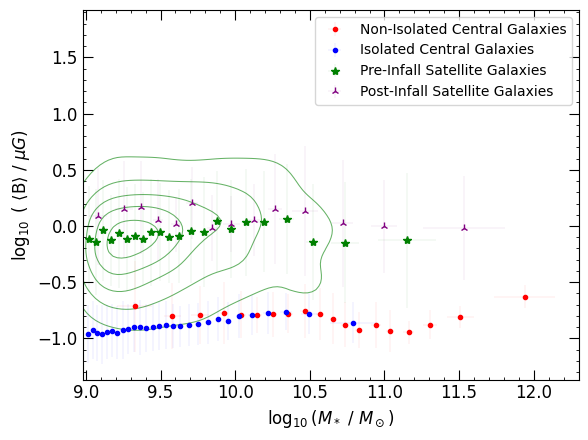

In [40]:
#pdf
plot_wcontour(isolated_centrals_mass_bin_log_sfri, isolated_centrals_bfld_bin_log_sfri,
            non_isolated_centrals_mass_bin_log_sfri, non_isolated_centrals_bfld_bin_log_sfri,
            pre_infall_1_mass_bin_log_sfri, pre_infall_1_bfld_bin_log_sfri, 
            post_infall_1_mass_bin_log_sfri, post_infall_1_bfld_bin_log_sfri,
            isolated_centrals_mass_bin_er_log_sfri, isolated_centrals_bfld_bin_er_log_sfri,
            non_isolated_centrals_mass_bin_er_log_sfri, non_isolated_centrals_bfld_bin_er_log_sfri,
            pre_infall_1_mass_bin_er_log_sfri, pre_infall_1_bfld_bin_er_log_sfri,
            post_infall_1_mass_bin_er_log_sfri, post_infall_1_bfld_bin_er_log_sfri,
            pre_infall_1_mass_log_sfri, pre_infall_1_bfld_log_sfri,
            filename = 'binned-cross-1R200-contour-all-sfri.pdf', log=False, title="", contAlph=0.6, alph=0.3)

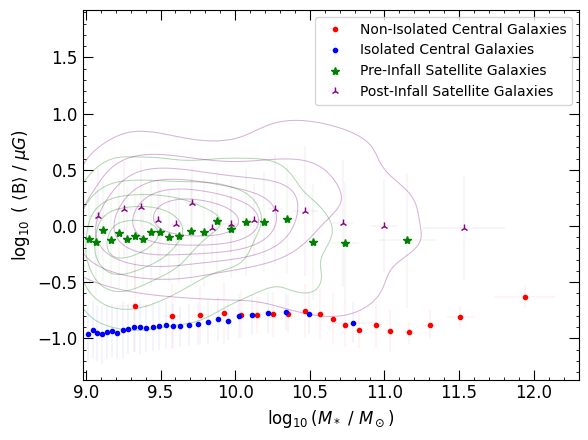

In [41]:
#pdf
plot_wcontour(isolated_centrals_mass_bin_log_sfri, isolated_centrals_bfld_bin_log_sfri,
            non_isolated_centrals_mass_bin_log_sfri, non_isolated_centrals_bfld_bin_log_sfri,
            pre_infall_1_mass_bin_log_sfri, pre_infall_1_bfld_bin_log_sfri, 
            post_infall_1_mass_bin_log_sfri, post_infall_1_bfld_bin_log_sfri,
            isolated_centrals_mass_bin_er_log_sfri, isolated_centrals_bfld_bin_er_log_sfri,
            non_isolated_centrals_mass_bin_er_log_sfri, non_isolated_centrals_bfld_bin_er_log_sfri,
            pre_infall_1_mass_bin_er_log_sfri, pre_infall_1_bfld_bin_er_log_sfri,
            post_infall_1_mass_bin_er_log_sfri, post_infall_1_bfld_bin_er_log_sfri,
            pre_infall_1_mass_log_sfri, pre_infall_1_bfld_log_sfri,
            post_infall_1_mass_log_sfri, post_infall_1_bfld_log_sfri,
            filename = 'binned-cross-1R200-contour-post-andpre-all-sfri.pdf', log=False, title="", contAlph=0.3, alph=0.3)

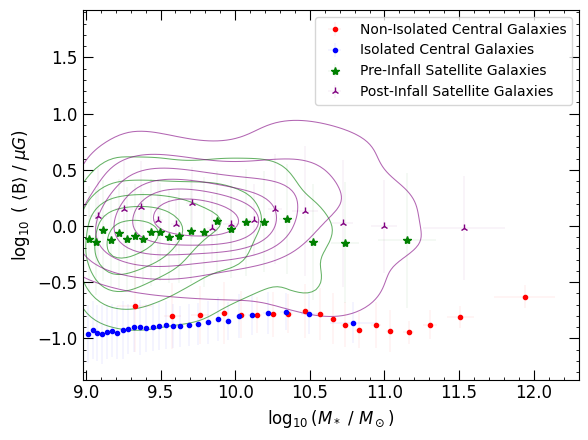

In [42]:
plot_wcontour(isolated_centrals_mass_bin_log_sfri, isolated_centrals_bfld_bin_log_sfri,
            non_isolated_centrals_mass_bin_log_sfri, non_isolated_centrals_bfld_bin_log_sfri,
            pre_infall_1_mass_bin_log_sfri, pre_infall_1_bfld_bin_log_sfri, 
            post_infall_1_mass_bin_log_sfri, post_infall_1_bfld_bin_log_sfri,
            isolated_centrals_mass_bin_er_log_sfri, isolated_centrals_bfld_bin_er_log_sfri,
            non_isolated_centrals_mass_bin_er_log_sfri, non_isolated_centrals_bfld_bin_er_log_sfri,
            pre_infall_1_mass_bin_er_log_sfri, pre_infall_1_bfld_bin_er_log_sfri,
            post_infall_1_mass_bin_er_log_sfri, post_infall_1_bfld_bin_er_log_sfri,
            pre_infall_1_mass_log_sfri, pre_infall_1_bfld_log_sfri,
            post_infall_1_mass_log_sfri, post_infall_1_bfld_log_sfri,
            filename = 'binned-cross-1R200-contour-post-nopre-all-sfri.pdf', log=False, title="", contAlph=0.6, alph=0.3)

# Get behind the figure

In [43]:
print(len(pre_infall_1_mass), len(pre_infall_1_bfld), len(pre_infall_1_sfri), len(pre_infall_1_ID))

7332 7332 7332 7332


In [44]:
print(pre_infall_1_mass)

[np.float32(558791700000.0), np.float32(171551460000.0), np.float32(192150200000.0), np.float32(289372440000.0), np.float32(192698550000.0), np.float32(223140360000.0), np.float32(201115710000.0), np.float32(236774640000.0), np.float32(83734815000.0), np.float32(168427320000.0), np.float32(100577210000.0), np.float32(107320250000.0), np.float32(29036093000.0), np.float32(44136755000.0), np.float32(77012390000.0), np.float32(39299270000.0), np.float32(41275900000.0), np.float32(23341218000.0), np.float32(47906505000.0), np.float32(45522715000.0), np.float32(25029323000.0), np.float32(31664820000.0), np.float32(42635280000.0), np.float32(11374942000.0), np.float32(34446970000.0), np.float32(28190452000.0), np.float32(18337368000.0), np.float32(31404696000.0), np.float32(3248093000.0), np.float32(10610979000.0), np.float32(19610532000.0), np.float32(10569805000.0), np.float32(17715710000.0), np.float32(12525568000.0), np.float32(12477709000.0), np.float32(4171533300.0), np.float32(9601987

In [45]:
print(len(isolated_centrals_mass))
print(len(isolated_centrals_mass_sort))

10293
10153


In [46]:
#remove nans
nanmask = np.isnan(pre_infall_1_bfld)
pre_infall_1_mass_nonnan = np.array(pre_infall_1_mass)[~nanmask]
pre_infall_1_bfld_nonnan = np.array(pre_infall_1_bfld)[~nanmask]
pre_infall_1_ID_nonnan = np.array(pre_infall_1_ID)[~nanmask]
pre_infall_1_sfri_nonnan = np.array(pre_infall_1_sfri)[~nanmask]

#remove nans
nanmask = np.isnan(post_infall_1_bfld)
post_infall_1_mass_nonnan = np.array(post_infall_1_mass)[~nanmask]
post_infall_1_bfld_nonnan = np.array(post_infall_1_bfld)[~nanmask]
post_infall_1_ID_nonnan = np.array(post_infall_1_ID)[~nanmask]
post_infall_1_sfri_nonnan = np.array(post_infall_1_sfri)[~nanmask]
#remove nans
nanmask = np.isnan(isolated_centrals_bfld)
isolated_centrals_mass_nonnan = np.array(isolated_centrals_mass)[~nanmask]
isolated_centrals_bfld_nonnan = np.array(isolated_centrals_bfld)[~nanmask]
isolated_centrals_ID_nonnan = np.array(isolated_centrals_ids)[~nanmask]
isolated_centrals_sfri_nonnan = np.array(isolated_centrals_sfri)[~nanmask]
#remove nans
nanmask = np.isnan(non_isolated_centrals_bfld)
non_isolated_centrals_mass_nonnan = np.array(non_isolated_centrals_mass)[~nanmask]
non_isolated_centrals_bfld_nonnan = np.array(non_isolated_centrals_bfld)[~nanmask]
non_isolated_centrals_ID_nonnan = np.array(non_isolated_centrals_ids)[~nanmask]
non_isolated_centrals_sfri_nonnan = np.array(non_isolated_centrals_sfri)[~nanmask]

In [ ]:
import pandas as pd


mask = np.where(np.atleast_1d(pre_infall_1_sfri_nonnan) != 0)
csv_pre_infall_1_mass_only_sfri = np.array(pre_infall_1_mass_nonnan)[mask]
csv_pre_infall_1_bfld_only_sfri = np.array(pre_infall_1_bfld_nonnan)[mask]
csv_pre_infall_1_ids_only_sfri = np.array(pre_infall_1_ID_nonnan)[mask]
csv_pre_infall_1_sfri_only_sfri = np.array(pre_infall_1_sfri_nonnan)[mask]

mask = np.where(np.atleast_1d(post_infall_1_sfri_nonnan) != 0)
csv_post_infall_1_mass_only_sfri = np.array(post_infall_1_mass_nonnan)[mask]
csv_post_infall_1_bfld_only_sfri = np.array(post_infall_1_bfld_nonnan)[mask]
csv_post_infall_1_ids_only_sfri = np.array(post_infall_1_ID_nonnan)[mask]

mask = np.where(np.atleast_1d(isolated_centrals_sfri_nonnan) != 0)
csv_isolated_centrals_mass_only_sfri = np.array(isolated_centrals_mass_nonnan)[mask]
csv_isolated_centrals_bfld_only_sfri = np.array(isolated_centrals_bfld_nonnan)[mask]
csv_isolated_centrals_ids_only_sfri = np.array(isolated_centrals_ID_nonnan)[mask]

mask = np.where(np.atleast_1d(non_isolated_centrals_sfri_nonnan) != 0)
csv_non_isolated_centrals_mass_only_sfri = np.array(non_isolated_centrals_mass_nonnan)[mask]
csv_non_isolated_centrals_bfld_only_sfri = np.array(non_isolated_centrals_bfld_nonnan)[mask]
csv_non_isolated_centrals_ids_only_sfri = np.array(non_isolated_centrals_ID_nonnan)[mask]




In [48]:
print(f"isolatedcentrals len mass: {len(isolated_centrals_mass_sort_sfri)}")
print(f"isolatedcentrals len mass with sfri: {len(csv_isolated_centrals_mass_only_sfri)}")

print(f"non_isolated_centrals len mass: {len(non_isolated_centrals_mass_sort_sfri)}")
print(f"non_isolated_centrals len mass with sfri: {len(csv_non_isolated_centrals_mass_only_sfri)}")

print(f"pre_infall_1 len mass: {len(pre_infall_1_mass_sort_sfri)}")
print(f"pre_infall_1 len mass with sfri: {len(csv_pre_infall_1_mass_only_sfri)}")

print(f"post_infall_1 len mass: {len(post_infall_1_mass_sort_sfri)}")
print(f"post_infall_1 len mass with sfri: {len(csv_post_infall_1_mass_only_sfri)}")


isolatedcentrals len mass: 9778
isolatedcentrals len mass with sfri: 9778
non_isolated_centrals len mass: 1682
non_isolated_centrals len mass with sfri: 1682
pre_infall_1 len mass: 3648
pre_infall_1 len mass with sfri: 3648
post_infall_1 len mass: 202
post_infall_1 len mass with sfri: 202


In [52]:
# Save the data to CSV files

# Pre-infall data
df_pre_infall = pd.DataFrame({
    'Mass': csv_pre_infall_1_mass_only_sfri,
    'Bfld': csv_pre_infall_1_bfld_only_sfri,
    'ID': csv_pre_infall_1_ids_only_sfri
})
df_pre_infall.to_csv('pre_infall_1_only_sfri.csv', index=False)

# Post-infall data
df_post_infall = pd.DataFrame({
    'Mass': csv_post_infall_1_mass_only_sfri,
    'Bfld': csv_post_infall_1_bfld_only_sfri,
    'ID': csv_post_infall_1_ids_only_sfri
})
df_post_infall.to_csv('post_infall_1_only_sfri.csv', index=False)

# Isolated centrals data
df_isolated_centrals = pd.DataFrame({
    'Mass': csv_isolated_centrals_mass_only_sfri,
    'Bfld': csv_isolated_centrals_bfld_only_sfri,
    'ID': csv_isolated_centrals_ids_only_sfri
})
df_isolated_centrals.to_csv('isolated_centrals_only_sfri.csv', index=False)

# Non-isolated centrals data
df_non_isolated_centrals = pd.DataFrame({
    'Mass': csv_non_isolated_centrals_mass_only_sfri,
    'Bfld': csv_non_isolated_centrals_bfld_only_sfri,
    'ID': csv_non_isolated_centrals_ids_only_sfri
})
df_non_isolated_centrals.to_csv('non_isolated_centrals_only_sfri.csv', index=False)

df_all = pd.DataFrame({
    'ID': np.concatenate((csv_pre_infall_1_ids_only_sfri, csv_post_infall_1_ids_only_sfri, csv_isolated_centrals_ids_only_sfri, csv_non_isolated_centrals_ids_only_sfri)),
    'Mass': np.concatenate((csv_pre_infall_1_mass_only_sfri, csv_post_infall_1_mass_only_sfri, csv_isolated_centrals_mass_only_sfri, csv_non_isolated_centrals_mass_only_sfri)),
    'Bfld': np.concatenate((csv_pre_infall_1_bfld_only_sfri, csv_post_infall_1_bfld_only_sfri, csv_isolated_centrals_bfld_only_sfri, csv_non_isolated_centrals_bfld_only_sfri)),
    'Sfri': np.concatenate((pre_infall_1_sfri_nonnan, post_infall_1_sfri_nonnan, isolated_centrals_sfri_nonnan, non_isolated_centrals_sfri_nonnan)),
    'Type': np.concatenate((['Pre-Infall'] * len(csv_pre_infall_1_mass_only_sfri),
                            ['Post-Infall'] * len(csv_post_infall_1_mass_only_sfri),
                            ['Isolated Central'] * len(csv_isolated_centrals_mass_only_sfri),
                            ['Non-Isolated Central'] * len(csv_non_isolated_centrals_mass_only_sfri)))
})
df_all.to_csv('all_data_only_sfri.csv', index=False)

ValueError: All arrays must be of the same length